This project pulls data from Google BigQuery to analyze the new_york_citibike.citibike_trips database and predicts the length of a trip duration in minutes.  

About the data:
* tripduration - Trip Duration (in seconds)	
* starttime - Start Time, in NYC local time.	
* stoptime - Stop Time, in NYC local time.	
* start_station_id	- Start Station ID	
* start_station_name	- Start Station Name	
* start_station_latitude	- Start Station Latitude	
* start_station_longitude	- Start Station Longitude	
* end_station_id	- End Station ID	
* end_station_name	- End Station Name	
* end_station_latitude	- End Station Latitude	
* end_station_longitude	- End Station Longitude	
* bikeid	- Bike ID	
* usertype	- User Type (Customer = 24-hour pass or 7-day pass user, Subscriber = Annual Member)	
* birth_year	- Year of Birth	
* gender - Gender (unknown, male, female)	
* customer_plan - The name of the plan that determines the rate charged for the trip

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [ ]:
project_id = 'sixth-flag-316719'

In [ ]:
# Create a sampled DataFrame for training data between Apr 2017 and Mar 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
bike_trips = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (
       (EXTRACT (YEAR FROM starttime)=2017 AND
         (EXTRACT (MONTH FROM starttime)>=04 AND
           EXTRACT (MONTH FROM starttime)<=12)) OR
       (EXTRACT (YEAR FROM starttime)=2018 AND
         (EXTRACT (MONTH FROM starttime)>=01 OR
           EXTRACT (MONTH FROM starttime)<=03))
    )
    AND (tripduration>=3*60 AND tripduration<=2*60*60) # time ranges between 3 minutes and 2 hours
    AND birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
print('Full dataset has %d rows' % row_count)

Full dataset has 58937715 rows


In [ ]:
bike_trips.head(20)

,tripduration,starttime,stoptime,start_station_id,start_station_name,end_station_id,end_station_name,usertype,birth_year,gender
0,5.366667,2017-09-28 15:41:09.000,2017-09-28 15:46:31.000,128,MacDougal St & Prince St,3244,University Pl & E 8 St,Subscriber,1952,male
1,20.500000,2017-07-26 13:16:40.000,2017-07-26 13:37:10.000,483,E 12 St & 3 Ave,473,Rivington St & Chrystie St,Subscriber,1941,female
2,11.983333,2018-01-17 19:02:19.962,2018-01-17 19:14:19.336,268,Howard St & Centre St,2009,Catherine St & Monroe St,Subscriber,1949,male
3,8.783333,2017-06-20 13:34:17.000,2017-06-20 13:43:05.000,480,W 53 St & 10 Ave,468,Broadway & W 56 St,Subscriber,1950,male
4,8.833333,2017-04-22 18:32:42.000,2017-04-22 18:41:32.000,305,E 58 St & 3 Ave,455,1 Ave & E 44 St,Subscriber,2000,male
5,14.983333,2018-04-17 18:35:50.730,2018-04-17 18:50:49.990,267,Broadway & W 36 St,438,St Marks Pl & 1 Ave,Subscriber,1900,male
6,11.650000,2017-10-02 20:49:12.000,2017-10-02 21:00:52.000,3372,E 74 St & 1 Ave,3296,E 93 St & 2 Ave,Subscriber,1948,male
7,26.000000,2017-10-17 12:37:51.000,2017-10-17 13:03:52.000,282,Kent Ave & S 11 St,473,Rivington St & Chrystie St,Subscriber,1948,male
8,12.333333,2017-09-26 15:12:32.000,2017-09-26 15:24:52.000,3167,Amsterdam Ave & W 73 St,2006,Central Park S & 6 Ave,Subscriber,1951,male
9,7.550000,2017-11-01 12:23:10.000,2017-11-01 12:30:43.000,3244,University Pl & E 8 St,3632,E 12 St & Avenue B,Subscriber,1997,male


# Clean Data

In [ ]:
# Pre-process dates and time
 
bike_trips['Hour'] = bike_trips['starttime'].apply(lambda time: time.hour)
bike_trips['Month'] = bike_trips['starttime'].apply(lambda time: time.month)
bike_trips['Day of Week'] = bike_trips['starttime'].apply( lambda time: time.dayofweek)

In [ ]:
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
bike_trips = bike_trips.drop(['starttime', 'stoptime'], axis=1)

In [ ]:
bike_trips['usertype'].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [ ]:
# Map user type to 0 for customer and 1 for subscriber
 
bike_trips['usertype'] = bike_trips['usertype'].map({'Customer':0, 'Subscriber':1})

In [ ]:
bike_trips['gender'].unique()

array(['male', 'female', 'unknown'], dtype=object)

In [ ]:
# Map gender to numeric variables
 
bike_trips['gender'] = bike_trips['gender'].map({'male':0, 'female':1, 'unknown':2})

In [ ]:
# drop station names since we have station id
 
bike_trips = bike_trips.drop(['start_station_name', 'end_station_name'], axis=1)

In [ ]:
bike_trips

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
bike_trips.dropna(inplace=True)

In [ ]:
len(bike_trips)

11633

In [ ]:
print('Number of different start stations:', bike_trips['start_station_id'].nunique())
print('Number of different end stations:', bike_trips['end_station_id'].nunique())

Number of different start stations: 725
Number of different end stations: 734


In [ ]:
print('Minimum start station id:', bike_trips['start_station_id'].min())
print('Minimum end station id:', bike_trips['end_station_id'].min())

Minimum start station id: 72
Minimum end station id: 72


In [ ]:
print('Max start station id:', bike_trips['start_station_id'].max())
print('Max end station id:', bike_trips['end_station_id'].max())

Max start station id: 3680
Max end station id: 3684


In [ ]:
bike_trips.describe()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000,11633.000000
mean,13.396304,1401.709275,1390.527121,0.955901,1978.916101,0.301298,13.808906,6.523769,2.812000
std,10.098526,1369.745893,1367.923336,0.205323,12.015236,0.517153,4.889426,2.933579,1.900007
min,3.000000,72.000000,72.000000,0.000000,1887.000000,0.000000,0.000000,1.000000,0.000000
25%,6.483333,364.000000,364.000000,1.000000,1970.000000,0.000000,9.000000,4.000000,1.000000
50%,10.316667,491.000000,491.000000,1.000000,1982.000000,0.000000,14.000000,6.000000,3.000000
75%,17.083333,3158.000000,3155.000000,1.000000,1989.000000,1.000000,18.000000,9.000000,4.000000
max,118.050000,3680.000000,3684.000000,1.000000,2002.000000,2.000000,23.000000,12.000000,6.000000


In [ ]:
# Save bike_trip to Google drive

from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
bike_trips.to_csv('bike_trips.csv')
!cp bike_trips.csv "drive/My Drive/Projects/Streamlit/Regression_BigQuery"

link for Data Studio dashboard

https://datastudio.google.com/reporting/e4efbd5e-adae-43ab-9120-ab610c823013

# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Stacked histogram showing trip durations based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==0]['tripduration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==1]['tripduration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==2]['tripduration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the gender column', xaxis_title='Gender') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing trip durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=bike_trips[bike_trips['usertype']==0]['tripduration'], name="Customer"))
fig2.add_trace(go.Histogram(x=bike_trips[bike_trips['usertype']==1]['tripduration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the usertype column', xaxis_title='usertype') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=bike_trips['Day of Week'].unique(), y=bike_trips.groupby('Day of Week')['tripduration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=bike_trips['Day of Week'].unique(), y=bike_trips.groupby('Day of Week')['tripduration'].mean(), name="Average trip duration by week day"))
fig4.update_layout(title='Mean trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by month
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=bike_trips['Month'].unique(), y=bike_trips.groupby('Month')['tripduration'].mean(), name="Average trip duration by month"))
fig5.update_layout(title='Mean trip length by month', xaxis_title='Month')
 
# Bar graph of average trip length by gender
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=bike_trips['gender'].unique(), y=bike_trips.groupby('gender')['tripduration'].mean(), name="Average trip duration by gender"))
fig6.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6)
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:


The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`



<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://3677-35-230-45-245.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# Regression Models

 ## Train-test split, scale and fit

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = bike_trips.drop('tripduration',axis=1)
y = bike_trips['tripduration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Create the Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [ ]:
forest = RandomForestRegressor().fit(X_train, y_train)
GBr = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge = Ridge(alpha=0.1).fit(X_train,y_train)

## Model Evaluations

In [ ]:
 from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

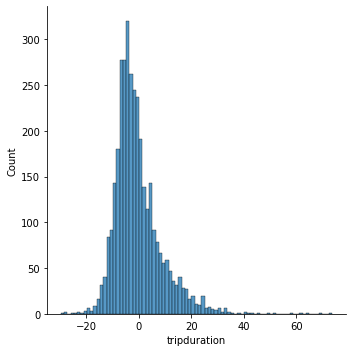

In [ ]:
# Histogram of Forest errors
forest_predictions = forest.predict(X_test)
forest_error = y_test - forest_predictions
sns.displot(forest_error)

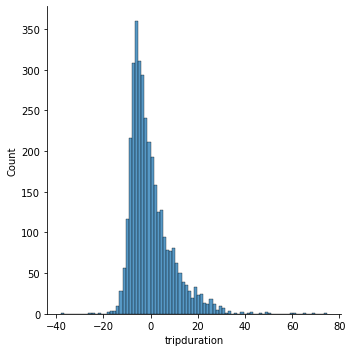

In [ ]:
# Histogram of Gradient errors
gb_predictions = GBr.predict(X_test)
gb_error = y_test - gb_predictions
sns.displot(gb_error)

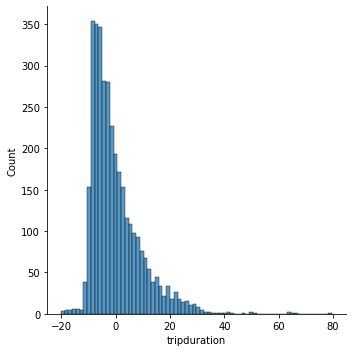

In [ ]:
# Histogram of ridge errors
ridge_predictions = ridge.predict(X_test)
ridge_error = y_test - ridge_predictions
sns.displot(ridge_error)

In [ ]:
print('Forest MSE:', mean_squared_error(y_test, forest_predictions))
print('Forest RMSE:', np.sqrt(mean_squared_error(y_test, forest_predictions)))

Forest MSE: 81.41905495496694
Forest RMSE: 9.023250797521198


In [ ]:
print('Gradient MSE:', mean_squared_error(y_test, gb_predictions))
print('Gradient RMSE:', np.sqrt(mean_squared_error(y_test, gb_predictions)))

Gradient MSE: 81.64321334217412
Gradient RMSE: 9.035663414612904


In [ ]:
print('Ridge MSE:', mean_squared_error(y_test, ridge_predictions))
print('Ridge RMSE:', np.sqrt(mean_squared_error(y_test, ridge_predictions)))

Ridge MSE: 86.75551099608306
Ridge RMSE: 9.314263846170725


In [ ]:
print('Forest MAE:', mean_absolute_error(y_test, forest_predictions))

Forest MAE: 6.62284002658312


In [ ]:
print('Gradient MAE:',mean_absolute_error(y_test, gb_predictions))

Gradient MAE: 6.6752064809969225


In [ ]:
print('Ridge MAE:',mean_absolute_error(y_test, ridge_predictions))

Ridge MAE: 6.943323037444937


## Save the Model

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import joblib

In [ ]:
# Save the models to Drive
 
joblib.dump(forest,'/content/drive/MyDrive/Projects/Streamlit/Regression_BigQuery/forest.joblib')
joblib.dump(GBr,'/content/drive/MyDrive/Projects/Streamlit/Regression_BigQuery/GBr.joblib')

['/content/drive/MyDrive/Projects/Streamlit/Regression_BigQuery/GBr.joblib']

# Predicting on brand new data

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import joblib
import pandas as pd
import numpy as np

In [ ]:
# Load the models
loaded_rf = joblib.load('/content/drive/MyDrive/Projects/Streamlit/Regression_BigQuery/forest.joblib')
 
# Load the model
loaded_GBr = joblib.load('/content/drive/MyDrive/Projects/Streamlit/Regression_BigQuery/GBr.joblib')

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
project_id = 'sixth-flag-316719'

In [ ]:
# Create a sampled DataFrame for predictions on Apr-May 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
evaluation_table = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (EXTRACT (YEAR FROM starttime)=2018 AND 
      (EXTRACT (MONTH FROM starttime)=04 OR 
        EXTRACT (MONTH FROM starttime)=05))
    AND (tripduration>=3*60 AND tripduration<=2*60*60) # Trip duration between 3 minutes and 2 hours
    AND  birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
# Pre-process dates and time
 
evaluation_table['Hour'] = evaluation_table['starttime'].apply(lambda time: time.hour)
evaluation_table['Month'] = evaluation_table['starttime'].apply(lambda time: time.month)
evaluation_table['Day of Week'] = evaluation_table['starttime'].apply( lambda time: time.dayofweek)
 
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
evaluation_table = evaluation_table.drop(['starttime', 'stoptime'], axis=1)
 
# Map user type to 0 for customer or 1 for subscriber
 
evaluation_table['usertype'] = evaluation_table['usertype'].map({'Customer':0, 'Subscriber':1})
 
# Map gender to numeric variables
 
evaluation_table['gender'] = evaluation_table['gender'].map({'male':0, 'female':1, 'unknown':2})
 
# drop additional unnecessary variables
 
evaluation_table = evaluation_table.drop(['start_station_name', 'end_station_name', 'tripduration'], axis=1) # Trip duration is the y-variable
 
evaluation_table.dropna(inplace=True)

In [ ]:
evaluation_table.head(3)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
0,443,3452,1,1950,0,17,5,2
1,72,3256,0,2001,1,12,5,5
2,3493,3160,0,1997,0,19,5,0


In [ ]:
evaluation_table.describe()

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,1935.000000,1935.000000,1935.00000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,1537.610853,1558.064083,0.87907,1978.229974,0.437726,13.869251,4.592765,2.833075
std,1421.266224,1419.897197,0.32613,11.554391,0.670800,4.796690,0.491446,1.929883
min,72.000000,72.000000,0.00000,1912.000000,0.000000,0.000000,4.000000,0.000000
25%,380.000000,382.000000,1.00000,1969.000000,0.000000,10.000000,4.000000,1.000000
50%,499.000000,504.000000,1.00000,1980.000000,0.000000,14.000000,5.000000,3.000000
75%,3223.000000,3223.000000,1.00000,1987.000000,1.000000,18.000000,5.000000,4.000000
max,3684.000000,3684.000000,1.00000,2001.000000,2.000000,23.000000,5.000000,6.000000


In [ ]:
import numpy as np

importances = loaded_GBr.feature_importances_

indices = np.argsort(importances)

Features = evaluation_table.columns

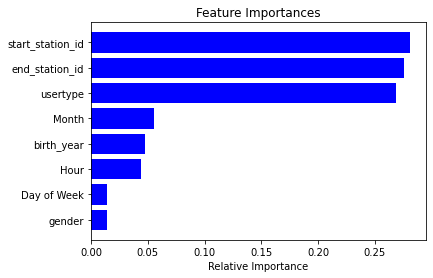

In [ ]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
RFpredictions = loaded_rf.predict(evaluation_table)
RFpredictions = pd.DataFrame(RFpredictions)

In [ ]:
GBpredictions = loaded_GBr.predict(evaluation_table)
GBpredictions = pd.DataFrame(GBpredictions)

In [ ]:
evaluation_table['RF_predicted duration'] = RFpredictions

In [ ]:
evaluation_table['GB_predicted duration'] = GBpredictions

In [ ]:
evaluation_table.head(15)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week,RF_predicted duration,GB_predicted duration
0,443,3452,1,1950,0,17,5,2,15.859667,12.938312
1,72,3256,0,2001,1,12,5,5,26.214000,31.654004
2,3493,3160,0,1997,0,19,5,0,30.817500,23.870896
3,267,2006,0,1998,0,14,5,4,27.901500,25.061639
4,349,291,1,1996,0,18,5,4,11.475667,12.415133
5,497,483,1,1955,0,9,5,0,9.004333,10.927848
6,3458,173,1,1957,0,14,5,2,16.386000,15.516173
7,173,3431,1,1960,0,12,4,2,10.089167,12.807296
8,2009,412,1,1961,0,12,5,0,16.974500,15.806472
9,3165,522,1,1962,0,21,5,1,21.921333,15.264273


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
 
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
mmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
gmap = {0:'Male', 1:'Female', 2:'Unknown'}
evaluation_table.sort_values('Day of Week', inplace=True)
evaluation_table['Day of Week'] = evaluation_table['Day of Week'].map(dmap)
evaluation_table['Month'] = evaluation_table['Month'].map(mmap)
evaluation_table['gender'] = evaluation_table['gender'].map(gmap)

In [ ]:
# Stacked histogram showing Gradient predicted duration based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']=='Male']['GB_predicted duration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']=='Female']['GB_predicted duration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']=='Unknown']['GB_predicted duration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing predicted duration based on the gender column', xaxis_title='Predicted trip duration') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing Gradient predicted durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==0]['GB_predicted duration'], name="Customer"))
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==1]['GB_predicted duration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing predicted durations based on the usertype column', xaxis_title='Predicted trip duration') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].mean(), name="Average predicted trip duration by week day"))
fig4.update_layout(title='Mean predicted trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by gender
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=evaluation_table['gender'].unique(), y=evaluation_table.groupby('gender')['GB_predicted duration'].mean(), name="Average predicted trip duration by gender"))
fig5.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in evaluation_table.columns],
        data=evaluation_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://4bda-34-125-11-151.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# Streamlit Model Deployment link
https://share.streamlit.io/taylorec/regrbq_streamlit/main/Reg_BQ.py